### Model In vs Out

/tmp/ipykernel_13019/699843578.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label_direction_encoded'] = label_encoder.fit_transform(train_df[INTEREST_LABEL])  # 'IN' -> 1, 'OUT' -> 0


Validation Accuracy: 1.0
LabelEncoder classes: ['IN' 'OUT']
LabelEncoder inverse transform: ['OUT' 'IN']
Updated CSV saved successfully.


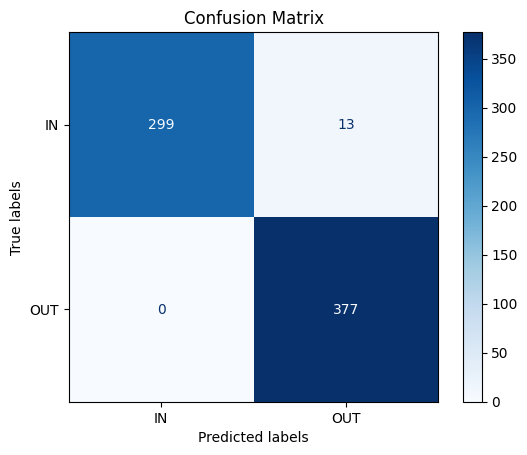

conf_interval
0.50-0.55      1
0.55-0.60      4
0.60-0.65      6
0.65-0.70      1
0.70-0.75      1
0.75-0.80      0
0.80-0.85      0
0.85-0.90      7
0.90-0.95      5
0.95-1.00    651
Name: count, dtype: int64
conf_interval
0.50-0.55    2
0.55-0.60    5
0.60-0.65    4
0.65-0.70    0
0.70-0.75    0
0.75-0.80    0
0.80-0.85    2
0.85-0.90    0
0.90-0.95    0
0.95-1.00    0
Name: count, dtype: int64


In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report,confusion_matrix
from utils import aggregate_and_compare_predictions, plot_confusion_matrix, plot_false_positives, calculate_confidence_distribution

BASE_IMAGES_PATH = '/home/diego/Documents/yolov7-tracker/imgs_conce'
BASE_FOLDER_NAME = 'results'
FILE_NAME = '120_conce_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, FILE_NAME)
INTEREST_LABEL = 'label_direction'

MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_inout_{FILE_NAME}')

df = pd.read_csv(CSV_FILE_PATH)

# df_filtered = df[(df[INTEREST_LABEL] == 'IN') | (df[INTEREST_LABEL] == 'OUT')] # FUNCIONA

# Aca puede pasar que tengo solo hasta el ID 600 con etiquetas, 
# por ende necesito menor que el ID 1300 y que tengan las etiqeutas IN or OUT, y no BAD ni blanks
train_df = df[(df['id'] < 1300) & (df[INTEREST_LABEL] == 'IN') | (df[INTEREST_LABEL] == 'OUT')]

# Pero para el predict, necesito todas las arriba de 1300 y sacar los BADs solo si es que hay anotadas
# si no da igual, ahora si hay IN or OUT, me va a servir para despues, pero pueden haber unos pocos o muchos
# solo me va a servir para la confusion matrix
predict_df = df[(df['id'] >= 1300) & (df[INTEREST_LABEL] != 'BAD')]


# Correctly encode 'IN' as 1 and 'OUT' as 0
label_encoder = LabelEncoder()
train_df['label_direction_encoded'] = label_encoder.fit_transform(train_df[INTEREST_LABEL])  # 'IN' -> 1, 'OUT' -> 0

not_imporant_features = ['id',
                         INTEREST_LABEL,
                         'label_direction_encoded',
                         'conf_score',
                         'k_fold',
                         'label_img',
                         'overlap',
                         'area',
                         'frame_number',
                         ]
# Define features (make sure to only include numeric columns and exclude any text columns)
features = [col for col in train_df.columns if col not in not_imporant_features and train_df[col].dtype in [np.int64, np.float64]]
target = 'label_direction_encoded'

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")



predict_df = predict_df.dropna(subset=features)
# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label_direction'] = predicted_labels
predict_df['model_label_direction_conf'] = predicted_confidences
predict_df['model_label_direction'] = label_encoder.inverse_transform(predict_df['model_label_direction'].astype(int))

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(MODEL_RESULT, index=False) 

label_encoder.classes_
label_encoder.inverse_transform([1,0])
print("LabelEncoder classes:", label_encoder.classes_)
print("LabelEncoder inverse transform:", label_encoder.inverse_transform([1, 0]))
print("Updated CSV saved successfully.")


################################################ TESTING ################################################
agg_df = aggregate_and_compare_predictions(final_df, 'model_label_direction', 'label_direction')
plot_confusion_matrix(agg_df)
#plot_false_positives(agg_df, final_df, img_name_col='img_name',true_label_col='label_direction', pred_label_col='model_label_direction', conf_col='model_label_direction_conf', base_img_path=BASE_IMAGES_PATH, save_path='logs/false_positive_images.png', nrows=2)


### CONFIDENCE DISTRIBUTION
only_predicted_values = final_df.dropna(subset=['model_label_direction', 'label_direction'])
TP_TN_final_value = only_predicted_values[(only_predicted_values['label_direction'] == only_predicted_values['model_label_direction'])]
FP_FN_final_value = only_predicted_values[(only_predicted_values['label_direction'] != only_predicted_values['model_label_direction'])]

true_positives_and_negatives = calculate_confidence_distribution(TP_TN_final_value, 'id', 'label_direction', 'model_label_direction', 'model_label_direction_conf')
false_positives_and_negatives = calculate_confidence_distribution(FP_FN_final_value, 'id', 'label_direction', 'model_label_direction', 'model_label_direction_conf')
print(true_positives_and_negatives)
print(false_positives_and_negatives)
